In [ ]:
#Import all Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import re
import spacy
import email
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from  sklearn.metrics import roc_auc_score
from sklearn import metrics
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#mount drive to import file
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read the file and extract only 5000 rows
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emails.csv",nrows=5000)

In [ ]:
emails = list(map(email.parser.Parser().parsestr,df['message']))
headings  = emails[0].keys()
for key in headings:
    df[key] = [doc[key] for doc in emails]
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [ ]:
df.to_csv("5000emails.csv")

In [ ]:
#feature Engineering of the data
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()
df.dtypes

file                         object
message                      object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
body                         object
user                         object
dtype: object

In [ ]:
#Data Cleaning
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)

In [ ]:
df.drop_duplicates()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,user,Subject_new,body_new
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,,here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,test,test successful way to go
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,arnold-j/deleted_items/135.,Message-ID: <1618629.1075852693101.JavaMail.ev...,<1618629.1075852693101.JavaMail.evans@thyme>,2001-10-09 14:50:14-07:00,m..schmidt@enron.com,None,Enron Mentions,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,,,,"\JARNOLD (Non-Privileged)\Arnold, John\Deleted...",Arnold-J,JARNOLD (Non-Privileged).pst,STOCKWATCH Enron higher after Merrill Lynch's ...,arnold-j,enron mentions,stockwatch enron higher after merrill lynchs c...
4996,arnold-j/deleted_items/136.,Message-ID: <25218462.1075852693367.JavaMail.e...,<25218462.1075852693367.JavaMail.evans@thyme>,2001-10-09 10:46:00-07:00,caroline.abramo@enron.com,john.arnold@enron.com,RE: Back office issues,1.0,text/plain; charset=us-ascii,7bit,...,"Arnold, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,"\JARNOLD (Non-Privileged)\Arnold, John\Deleted...",Arnold-J,JARNOLD (Non-Privileged).pst,WE ARE HAVING A MEETING WITH FRED AND MICHELLE...,arnold-j,back office issues,we are having a meeting with fred and michelle...
4997,arnold-j/deleted_items/137.,Message-ID: <20671206.1075852693390.JavaMail.e...,<20671206.1075852693390.JavaMail.evans@thyme>,2001-10-09 07:23:43-07:00,scott.tanner@truequote.com,john.arnold@enron.com,APB,1.0,text/plain; charset=us-ascii,7bit,...,john.arnold@enron.com; <??Sjohn.arnold@enron.c...,,,"\JARNOLD (Non-Privileged)\Arnold, John\Deleted...",Arnold-J,JARNOLD (Non-Privileged).pst,Please click on the link below for a Happy Hou...,arnold-j,apb,please click on the link below for a happy hou...
4998,arnold-j/deleted_items/138.,Message-ID: <31930685.1075852693414.JavaMai

In [ ]:
#Removing null values
null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
#using polarity for sentiment analysis
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [ ]:
#using regextokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['body_new'].apply(tokenizer.tokenize)

In [ ]:
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

802809 words total, with a vocabulary size of 26084


In [ ]:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('the', 33837),
 ('to', 26564),
 ('and', 14703),
 ('of', 13090),
 ('a', 12838),
 ('you', 10333),
 ('in', 9920),
 ('for', 9434),
 ('on', 9317),
 ('i', 8589),
 ('is', 8368),
 ('this', 5955),
 ('that', 5599),
 ('be', 5384),
 ('from', 5143),
 ('with', 4857),
 ('have', 4816),
 ('will', 4748),
 ('pm', 4666),
 ('are', 4637),
 ('we', 4433),
 ('at', 4376),
 ('am', 4347),
 ('as', 4230),
 ('your', 4204),
 ('it', 4088),
 ('subject', 3815),
 ('if', 3785),
 ('by', 3779),
 ('or', 3620),
 ('phillip', 3239),
 ('cc', 3130),
 ('not', 3108),
 ('john', 3059),
 ('please', 2874),
 ('email', 2597),
 ('would', 2538),
 ('gas', 2399),
 ('can', 2336),
 ('me', 2250),
 ('enron', 2228),
 ('an', 2055),
 ('any', 2009),
 ('all', 2000),
 ('but', 1916),
 ('was', 1902),
 ('do', 1730),
 ('has', 1720),
 ('get', 1657),
 ('what', 1620),
 ('my', 1583),
 ('our', 1568),
 ('about', 1516),
 ('up', 1506),
 ('k', 1496),
 ('out', 1492),
 ('more', 1471),
 ('they', 1469),
 ('new', 1414),
 ('its', 1409),
 ('time', 1397),
 ('so', 1373),

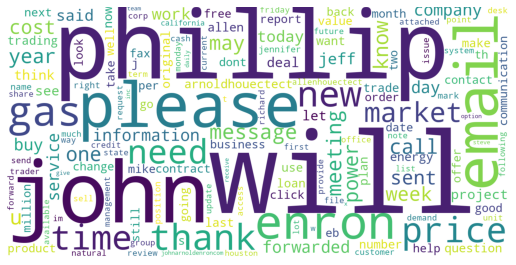

In [ ]:
#printing word frequencies
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['body_new']))  
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
#Extract scores from the message body
df['scores'] = df['body_new'].apply(lambda review: analyser.polarity_scores(review))
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-bcc,X-Folder,X-Origin,X-FileName,body,user,Subject_new,body_new,description_lengths,scores
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp..."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp..."
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp..."


In [ ]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Folder,X-Origin,X-FileName,body,user,Subject_new,body_new,description_lengths,scores,compound
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400


In [ ]:
#assign class to emotions
def Sentimnt(x):
    if x>= 0.05:
        return "Happy"
    elif x<= -0.05:
        return "Sad"
    else:
        return "Neutral"

df['Sentiment'] = df['compound'].apply(Sentimnt)


df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Origin,X-FileName,body,user,Subject_new,body_new,description_lengths,scores,compound,Sentiment
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,,here is our forecast,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,,traveling to have a business meeting takes the...,139,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.9313,Happy
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,...,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,test,test successful way to go,5,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,Happy
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,,randy can you send me a schedule of the sala...,34,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,...,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,hello,lets shoot for tuesday at,5,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,Sad


In [ ]:
var1 = df.groupby('Sentiment').count()['body_new'].reset_index().sort_values(by='body_new',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =var1.Sentiment,
    values = var1.body_new,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

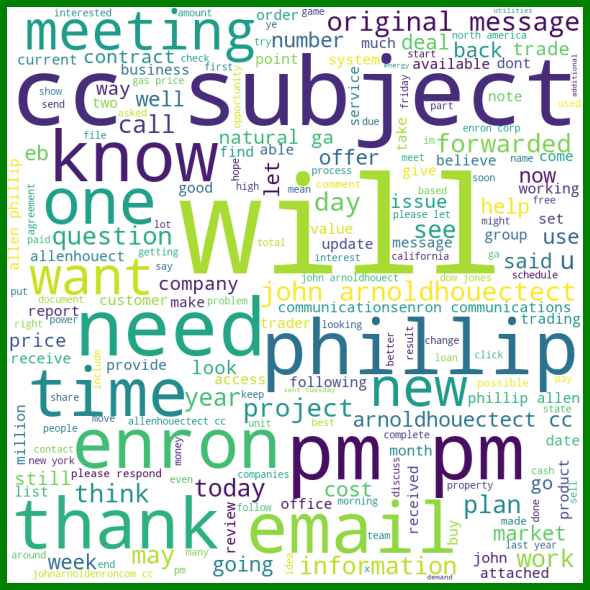

In [ ]:
#WordCloud showing Happy words
comment_words = '' 
stopwords = set(STOPWORDS) 
  
df_Happy = df[df["Sentiment"]== "Happy"] 
# iterate through the csv file 
for val in df_Happy.body_new: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "green") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

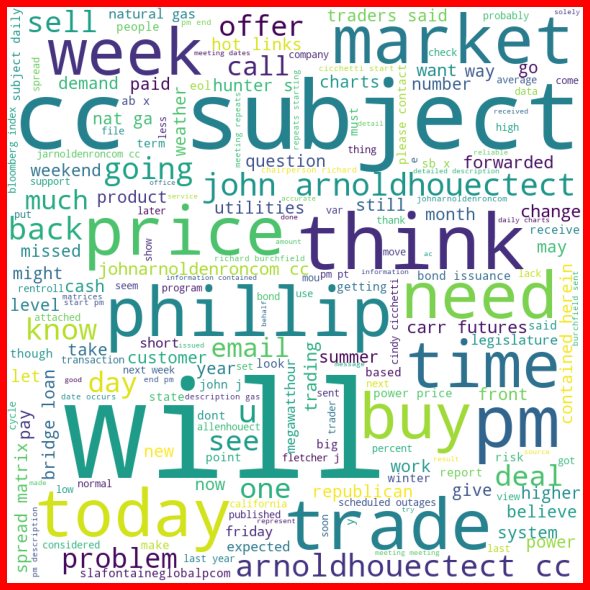

In [ ]:
#WordCloud showing Sad words
comment_words = '' 
stopwords = set(STOPWORDS) 
  
df_Sad = df[df["Sentiment"]== "Sad"] 
# iterate through the csv file 
for val in df_Sad.body_new: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "red") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

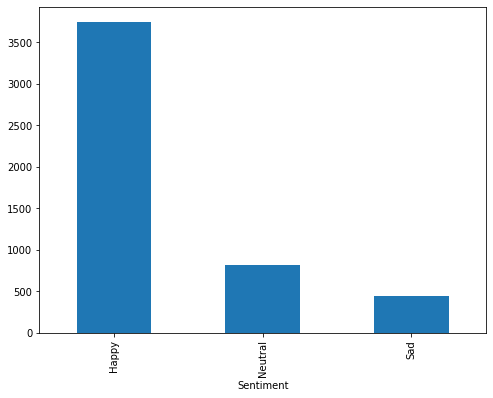

In [ ]:
#Visualising imbalances in the classes
fig = plt.figure(figsize=(8,6))
df.groupby('Sentiment').body_new.count().plot.bar(ylim=0)
plt.show()

In [ ]:
new_df = df[['body_new','Sentiment']].copy()
new_df.head()

,body_new,Sentiment
0,here is our forecast,Neutral
1,traveling to have a business meeting takes the...,Happy
2,test successful way to go,Happy
3,randy can you send me a schedule of the sala...,Neutral
4,lets shoot for tuesday at,Sad


In [ ]:
#mapping emoions to numerical values
dict = {'Neutral' : 0, 'Happy' : 1, 'Sad' : 2}
new_df.replace({"Sentiment": dict})

,body_new,Sentiment
0,here is our forecast,0
1,traveling to have a business meeting takes the...,1
2,test successful way to go,1
3,randy can you send me a schedule of the sala...,0
4,lets shoot for tuesday at,2
...,...,...
4995,stockwatch enron higher after merrill lynchs c...,1
4996,we are having a meeting with fred and michelle...,2
4997,please click on the link below for a happy hou...,1
4998,no need to eliminate specialization but there ...,1


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(new_df.body_new).toarray()
label = df.Sentiment
features.shape

(5000, 22956)

In [ ]:
#Training the imbalnce classes using Naive bayes
x_train, x_test, y_train, y_test = train_test_split(features,label,test_size=0.3,random_state=42)
NB = MultinomialNB().fit(x_train, y_train)
pred_Imb = NB.predict(x_test)
print(classification_report(y_test,pred_Imb))

              precision    recall  f1-score   support

       Happy       0.78      0.99      0.87      1120
     Neutral       0.81      0.22      0.35       247
         Sad       0.95      0.14      0.25       133

    accuracy                           0.79      1500
   macro avg       0.85      0.45      0.49      1500
weighted avg       0.80      0.79      0.73      1500



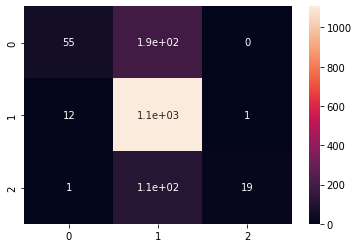

In [ ]:
#visualising confusion matrics on the imbalanced data
cm = confusion_matrix(y_test,pred_Imb, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm, annot=True)

In [ ]:
y_pred_proba = NB.predict_proba(x_test)

In [ ]:
#ROCAUC Score for imbalance classes
y_pred_proba = NB.predict_proba(x_test)
Imbalance_roc_score = roc_auc_score(y_test,y_pred_proba, multi_class="ovo")
Imbalance_roc_score

0.8316788165831003

In [ ]:
#Using RandomUndersampler to balance the classes
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(features, label)
X_train, x_test, Y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
#Training with LinearSVM after Undersamping
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_train, Y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
SVM =calibrator.fit(X_train, Y_train)
pred_sgd = SVM.predict(x_test)
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

       Happy       0.89      0.85      0.87       136
     Neutral       0.88      0.95      0.92       132
         Sad       0.91      0.88      0.90       132

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.89       400
weighted avg       0.90      0.90      0.89       400



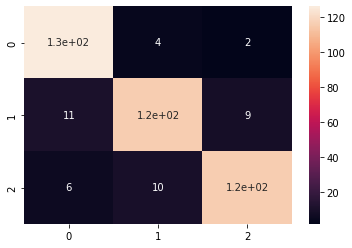

In [ ]:
#visualising confusion matrics
cm1 = confusion_matrix(y_test,pred_sgd, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm1, annot=True)

In [ ]:
#ROCAUC Score after using LinearSVM with undersampling
y_pred_proba = SVM.predict_proba(x_test)
SVMUndersampling_roc_score = roc_auc_score(y_test,y_pred_proba, multi_class="ovo")
SVMUndersampling_roc_score

0.970305776121284

In [ ]:
#Using Naive bayes to train the undersampled data
NB = MultinomialNB().fit(X_train, Y_train)
pred_NB = NB.predict(x_test)
print(classification_report(y_test,pred_NB))

              precision    recall  f1-score   support

       Happy       0.76      0.79      0.77       136
     Neutral       0.88      0.66      0.75       132
         Sad       0.72      0.87      0.79       132

    accuracy                           0.77       400
   macro avg       0.79      0.77      0.77       400
weighted avg       0.79      0.77      0.77       400



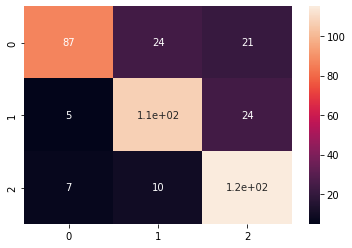

In [ ]:
#Visualising the model
cm2 = confusion_matrix(y_test,pred_NB, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm2, annot=True)

In [ ]:
#ROCAUC Score after using NB with undersampling
y_pred_proba = NB.predict_proba(x_test)
NBUndersampling_roc_score = roc_auc_score(y_test,y_pred_proba, multi_class="ovo")
NBUndersampling_roc_score

0.9220649003403013

In [ ]:
#Using smote method to balance the imbalanced data
smote = SMOTE(random_state=42,k_neighbors=5)
X_smote,y_smote = smote.fit_resample(features,label)

In [ ]:
#Usinig LinearSVM with smote
x_train, x_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3,random_state=42)
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(x_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
SVM =calibrator.fit(x_train, y_train)
pred_sgd = SVM.predict(x_test)
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

       Happy       0.99      0.97      0.98      1168
     Neutral       0.96      0.99      0.97      1094
         Sad       0.97      0.97      0.97      1108

    accuracy                           0.97      3370
   macro avg       0.97      0.97      0.97      3370
weighted avg       0.97      0.97      0.97      3370



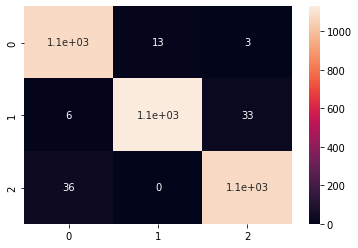

In [ ]:
#Visualising the data
cm3 = confusion_matrix(y_test,pred_sgd, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm3, annot=True)

In [ ]:
#ROCAUC Score after using LinearSVM with Smote
y_pred_proba = SVM.predict_proba(x_test)
SVMSmote_roc_score = roc_auc_score(y_test,y_pred_proba, multi_class="ovo")
SVMSmote_roc_score

0.9970418935434383

In [ ]:
#Using Naive bayes with smote
NB = MultinomialNB().fit(x_train, y_train)
pred_NB = NB.predict(x_test)
print(classification_report(y_test,pred_NB))

              precision    recall  f1-score   support

       Happy       0.90      0.89      0.89      1168
     Neutral       0.95      0.91      0.93      1094
         Sad       0.89      0.94      0.91      1108

    accuracy                           0.91      3370
   macro avg       0.91      0.91      0.91      3370
weighted avg       0.91      0.91      0.91      3370



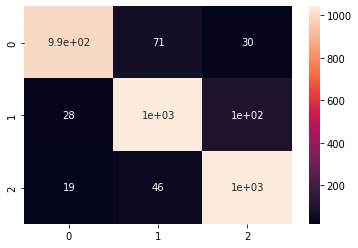

In [ ]:
#Visualise the data
cm3 = confusion_matrix(y_test,pred_NB, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm3, annot=True)

In [ ]:
#ROCAUC Score after using NB with Smote
y_pred_proba = NB.predict_proba(x_test)
NBSmote_roc_score = roc_auc_score(y_test,y_pred_proba, multi_class="ovo")
NBSmote_roc_score

0.9731171275809526

In [ ]:
#Using randomoversampling to balance the class
ros = RandomOverSampler(random_state=42)
X_ROS, y_ROS = ros.fit_resample(features, label)

In [ ]:
x_train, X_test, y_train, Y_test = train_test_split(X_ROS,y_ROS,test_size=0.3,random_state=42)

In [ ]:
#using LinearSVM with oversampling
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(x_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
SVM =calibrator.fit(x_train, y_train)
pred_sgd = SVM.predict(X_test)
print(classification_report(Y_test,pred_sgd))

              precision    recall  f1-score   support

       Happy       0.99      0.97      0.98      1168
     Neutral       0.98      0.99      0.99      1094
         Sad       0.99      0.99      0.99      1108

    accuracy                           0.99      3370
   macro avg       0.99      0.99      0.99      3370
weighted avg       0.99      0.99      0.99      3370



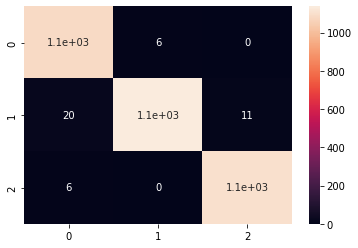

In [ ]:
#Visualising 
cm5 = confusion_matrix(Y_test,pred_sgd, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm5, annot=True)

In [ ]:
#ROCAUC Score after using LinearSVM with Oversampling
y_pred_proba = SVM.predict_proba(X_test)
OVersamplingSVM_roc_score = roc_auc_score(Y_test,y_pred_proba, multi_class="ovo")
OVersamplingSVM_roc_score

0.9984939425988922

In [ ]:
#using Naive bayes with oversampling
NB = MultinomialNB().fit(x_train, y_train)
pred_NOV = NB.predict(X_test)
print(classification_report(Y_test,pred_NOV))

              precision    recall  f1-score   support

       Happy       0.97      0.87      0.92      1168
     Neutral       0.94      0.94      0.94      1094
         Sad       0.87      0.96      0.91      1108

    accuracy                           0.92      3370
   macro avg       0.93      0.92      0.92      3370
weighted avg       0.93      0.92      0.92      3370



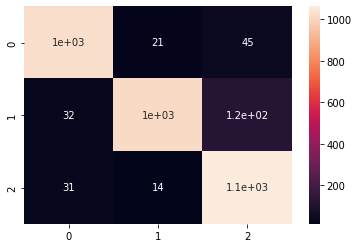

In [ ]:
#Visualising
cm6 = confusion_matrix(Y_test,pred_NOV, labels = ["Neutral","Happy","Sad"])
sb.heatmap(cm6, annot=True)

In [ ]:
#ROCAUC Score after using NB with Oversampling
y_pred_proba = NB.predict_proba(X_test)
OVersamplingNB_roc_score = roc_auc_score(Y_test,y_pred_proba, multi_class="ovo")
OVersamplingNB_roc_score

0.9767796399469741

In [ ]:
Roc_dict={"imbalance":Imbalance_roc_score,"UndersampleSVM":SVMUndersampling_roc_score,"UndersampledNB":NBUndersampling_roc_score,"SmoteSVM":SVMSmote_roc_score,
          "SmoteNB":NBSmote_roc_score,"OversampingSVM":OVersamplingSVM_roc_score,"OversamplingNB":OVersamplingNB_roc_score}
Accuracy_dict={"imbalance":0.79,"UndersampleSVM":0.88,"UndersampledNB":0.77,"SmoteSVM":0.97,"SmoteNB":0.91,"OversampingSVM":0.99,"OversamplingNB":0.92}
MacroAVG_dict={"imbalance":[0.85,0.45,0.49],"UndersampleSVM":[0.88,0.88,0.88],"UndersampledNB":[0.79,0.77,0.77],"SmoteSVM":[0.97,0.97,0.97],
               "SmoteNB":[0.91,0.91,0.91],"OversampingSVM":[0.99,0.99,0.99],"OversamplingNB":[0.93,0.92,0.92]}
Prec_data = {"imbalance":[0.78,0.81,0.95],"UndersampleSVM":[0.89,0.87,0.89],"UndersampledNB":[0.76,0.88,0.72],"SmoteSVM":[0.99,0.96,0.97],
               "SmoteNB":[0.90,0.95,0.89],"OversampingSVM":[0.99,0.98,0.99],"OversamplingNB":[0.97,0.94,0.87]}       
Recall_data = {"imbalance":[0.99,0.22,0.14],"UndersampleSVM":[0.83,0.94,0.88],"UndersampledNB":[0.79,0.66,0.87],"SmoteSVM":[0.97,0.99,0.97],
               "SmoteNB":[0.89,0.91,0.94],"OversampingSVM":[0.97,0.99,0.99],"OversamplingNB":[0.87,0.94,0.96]}   

In [ ]:
Prec_df = pd.DataFrame(Prec_data,index=["Happy","Neutral","Sad"])
Recall_df = pd.DataFrame(Recall_data,index=["Happy","Neutral","Sad"])


In [ ]:
plt.rcParams["figure.figsize"] = (8,5.5)

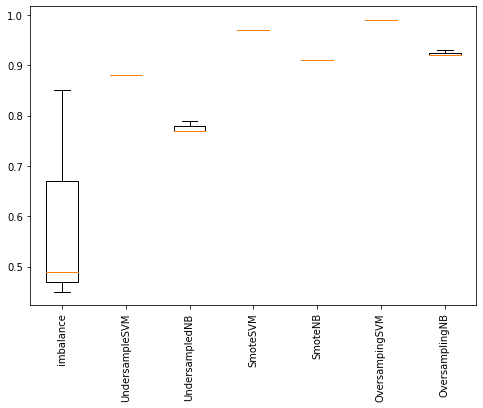

In [ ]:
labels, data = [*zip(*MacroAVG_dict.items())]

labels, data = MacroAVG_dict.keys(), MacroAVG_dict.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xticks(rotation='vertical')
plt.show()

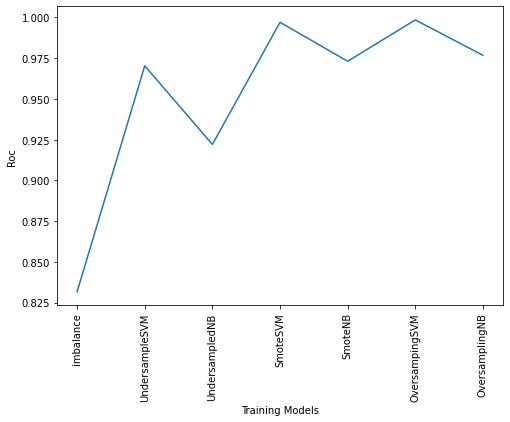

In [ ]:
x = list(Roc_dict.keys())
y = list(Roc_dict.values())

plt.plot(x,y)
plt.xlabel("Training Models")
plt.xticks(rotation='vertical')
plt.ylabel("Roc")
plt.show()

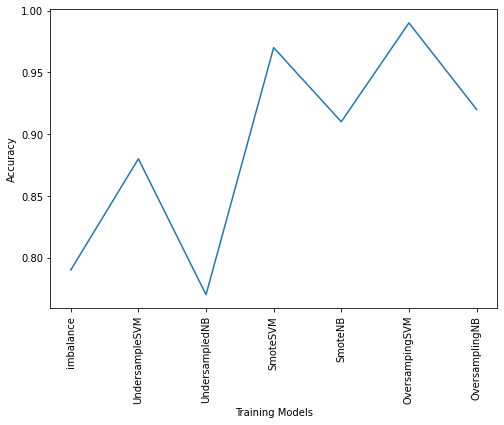

In [ ]:
x = list(Accuracy_dict.keys())
y = list(Accuracy_dict.values())

plt.plot(x,y)
plt.xlabel("Training Models")
plt.xticks(rotation='vertical')
plt.ylabel("Accuracy")
plt.show()

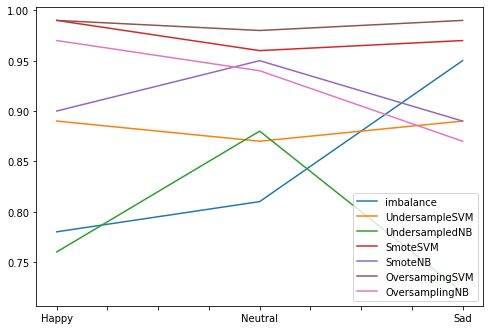

In [ ]:
Prec_df.plot.line()

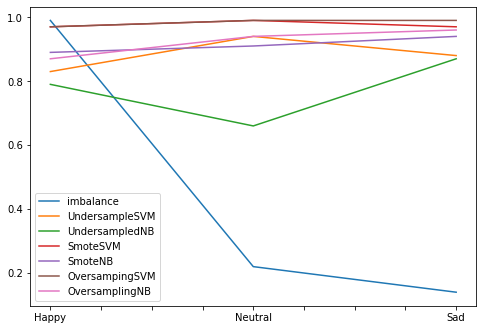

In [ ]:
Recall_df.plot.line()

In [ ]:
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jupyter nbconvert --to html Sentiment_Text_Classifier_Finall.ipynb

[NbConvertApp] WARNING | pattern 'Sentiment_Text_Classifier_Final.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes